# Python Libraries


In [1]:
import os
import itertools

import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import EfficientNetB3
from keras.applications import VGG16

# ignore the warnings
import warnings
warnings.filterwarnings('ignore')

# Read and Analyse Data

In [2]:
def loading_the_data(data_dir):
    filepaths = []
    labels = []

    folds = os.listdir(data_dir)

    for fold in folds:
        foldpath = os.path.join(data_dir, fold)
        filelist = os.listdir(foldpath)
        for file in filelist:
            fpath = os.path.join(foldpath, file)

            filepaths.append(fpath)
            labels.append(fold)

    Fseries = pd.Series(filepaths, name='filepaths')
    Lseries = pd.Series(labels, name='labels')

    df = pd.concat([Fseries, Lseries], axis=1)

    return df

In [3]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [5]:
data_dir = '/content/drive/MyDrive/tomato/train'
df = loading_the_data(data_dir)

df

filepaths  \
0      /content/drive/MyDrive/tomato/train/Tomato___T...   
1      /content/drive/MyDrive/tomato/train/Tomato___T...   
2      /content/drive/MyDrive/tomato/train/Tomato___T...   
3      /content/drive/MyDrive/tomato/train/Tomato___T...   
4      /content/drive/MyDrive/tomato/train/Tomato___T...   
...                                                  ...   
10071  /content/drive/MyDrive/tomato/train/Tomato___L...   
10072  /content/drive/MyDrive/tomato/train/Tomato___L...   
10073  /content/drive/MyDrive/tomato/train/Tomato___L...   
10074  /content/drive/MyDrive/tomato/train/Tomato___L...   
10075  /content/drive/MyDrive/tomato/train/Tomato___L...   

                                       labels  
0      Tomato___Tomato_Yellow_Leaf_Curl_Virus  
1      Tomato___Tomato_Yellow_Leaf_Curl_Virus  
2      Tomato___Tomato_Yellow_Leaf_Curl_Virus  
3      Tomato___Tomato_Yellow_Leaf_Curl_Virus  
4      Tomato___Tomato_Yellow_Leaf_Curl_Virus  
...                                       ...  
10071                    Tomato___Late_blight  
10072                    Tomato___Late_blight  
10073                    Tomato___Late_blight  
10074                    Tomato___Late_blight  
10075                    Tomato___Late_blight  

[10076 rows x 2 columns]

In [6]:
data_balance = df.labels.value_counts()
data_balance

labels
Tomato___Target_Spot                             1030
Tomato___Tomato_mosaic_virus                     1026
Tomato___Spider_mites Two-spotted_spider_mite    1020
Tomato___Tomato_Yellow_Leaf_Curl_Virus           1000
Tomato___healthy                                 1000
Tomato___Leaf_Mold                               1000
Tomato___Bacterial_spot                          1000
Tomato___Septoria_leaf_spot                      1000
Tomato___Early_blight                            1000
Tomato___Late_blight                             1000
Name: count, dtype: int64

In [ ]:
def custom_autopct(pct):
    total = sum(data_balance)
    val = int(round(pct*total/100.0))
    return "{:.1f}%\n({:d})".format(pct, val)


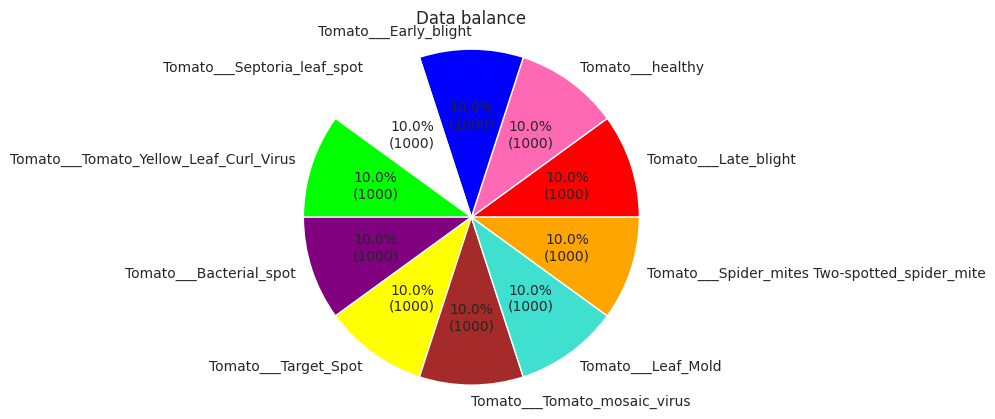

In [ ]:
plt.pie(data_balance, labels = data_balance.index, autopct=custom_autopct, colors = ["#FF0000", "#FF69B4", "#0000FF", "#FFFFFF", "#00FF00", "#800080", "#FFFF00", "#A52A2A", "#40E0D0", "#FFA500"])
plt.title("Data balance")
plt.axis("equal")
plt.show()

# Helper Functions

In [ ]:
def model_performance(history, Epochs):
    tr_acc = history.history['accuracy']
    tr_loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']

    Epochs = [i+1 for i in range(len(tr_acc))]

    plt.figure(figsize= (20, 8))
    plt.style.use('fivethirtyeight')

    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout
    plt.show()

In [ ]:
def model_evaluation(model):
    train_score = model.evaluate(train_gen, verbose= 1)
    valid_score = model.evaluate(valid_gen, verbose= 1)
    test_score = model.evaluate(test_gen, verbose= 1)

    print("Train Loss: ", train_score[0])
    print("Train Accuracy: ", train_score[1])
    print('-' * 20)
    print("Validation Loss: ", valid_score[0])
    print("Validation Accuracy: ", valid_score[1])
    print('-' * 20)
    print("Test Loss: ", test_score[0])
    print("Test Accuracy: ", test_score[1])

In [ ]:
def get_pred(model, test_gen):

    preds = model.predict(test_gen)
    y_pred = np.argmax(preds, axis = 1)

    return y_pred


In [ ]:
def plot_confusion_matrix(test_gen, y_pred):

    g_dict = test_gen.class_indices
    classes = list(g_dict.keys())

    cm = confusion_matrix(test_gen.classes, y_pred)

    plt.figure(figsize= (10, 10))
    plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation= 45, fontsize=8)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')


    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

    plt.show()

In [ ]:
def conv_block(filters, act='relu'):

    block = Sequential()
    block.add(Conv2D(filters, 3, activation=act, padding='same'))
    block.add(Conv2D(filters, 3, activation=act, padding='same'))
    block.add(BatchNormalization())
    block.add(MaxPooling2D())

    return block

In [ ]:
def dense_block(units, dropout_rate, act='relu'):

    block = Sequential()
    block.add(Dense(units, activation=act))
    block.add(BatchNormalization())
    block.add(Dropout(dropout_rate))

    return block

# Train - Test Split

In [ ]:
train_df, ts_df = train_test_split(df, train_size = 0.8, shuffle = True, random_state = 42)

valid_df, test_df = train_test_split(ts_df, train_size = 0.5, shuffle = True, random_state = 42)

In [ ]:
batch_size = 16
img_size = (224, 224)

tr_gen = ImageDataGenerator(rescale=1. / 255)
ts_gen = ImageDataGenerator(rescale=1. / 255)


train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= batch_size)

Found 8000 validated image filenames belonging to 10 classes.
Found 1000 validated image filenames belonging to 10 classes.
Found 1000 validated image filenames belonging to 10 classes.


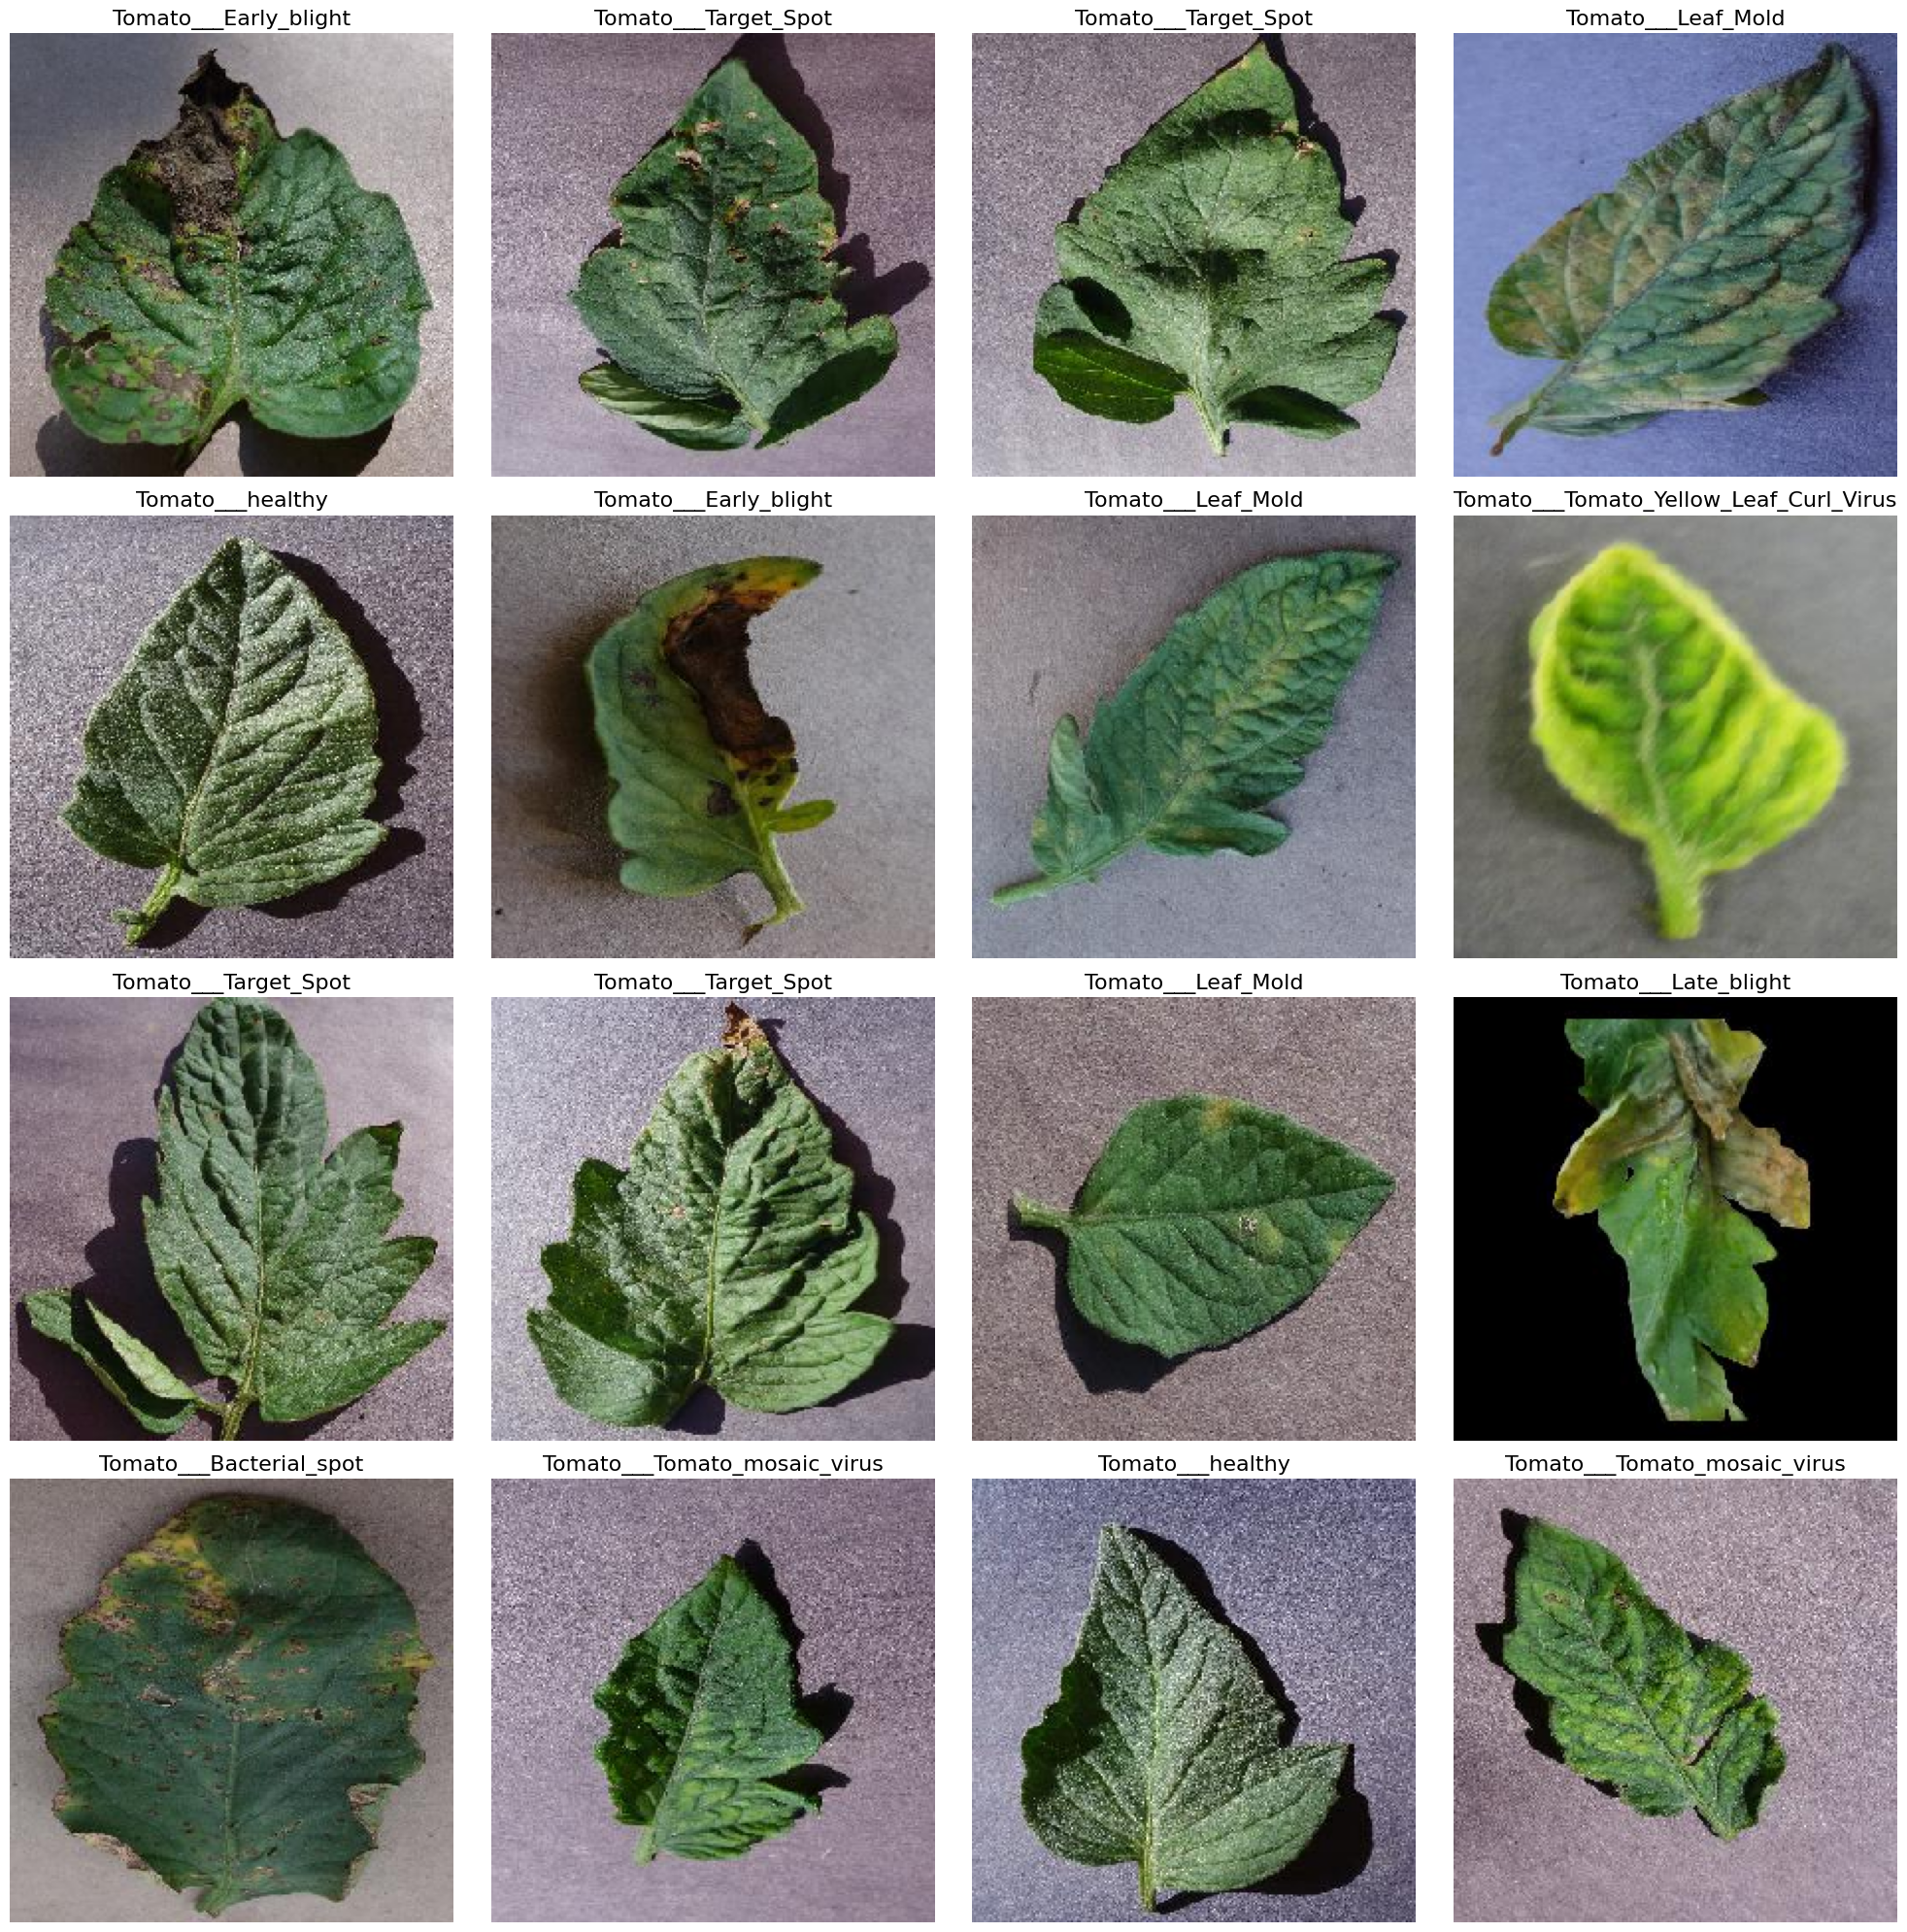

In [ ]:
g_dict = train_gen.class_indices
classes = list(g_dict.keys())
images, labels = next(train_gen)

# ploting the patch size samples
plt.figure(figsize= (20, 20))

for i in range(batch_size):
    plt.subplot(4, 4, i + 1)
    image = images[i]
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    class_name = classes[index]   # get class of image
    plt.title(class_name, color= 'black', fontsize= 16)
    plt.axis('off')
plt.tight_layout()
plt.show()

# Model Buildings

# CNN Model Building

In [ ]:
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

class_counts = len(list(train_gen.class_indices.keys()))

In [ ]:
cnn_model = Sequential()

cnn_model.add(Conv2D(filters=16, kernel_size=(3,3), padding="same", activation="relu", input_shape= img_shape))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPooling2D())

cnn_model.add(conv_block(32))

cnn_model.add(conv_block(64))

cnn_model.add(conv_block(128))

cnn_model.add(conv_block(256))

cnn_model.add(conv_block(512))

cnn_model.add(Flatten())

cnn_model.add(dense_block(256, 0.5))

cnn_model.add(dense_block(128, 0.3))

cnn_model.add(dense_block(64, 0.2))

cnn_model.add(dense_block(32, 0.2))

cnn_model.add(Dense(class_counts, activation = "softmax"))

In [ ]:
cnn_model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

cnn_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 56, 56, 32)     │        14,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_2 (Sequential)       │ (None, 28, 28, 64)     │        55,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_3 (Sequential)       │ (None, 14, 14, 128)    │       221,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_4 (Sequential)       │ (None, 7, 7, 256)      │       886,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_5 (Sequential)       │ (None, 3, 3, 512)      │     3,542,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_6 (Sequential)       │ (None, 256)            │     1,180,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_7 (Sequential)       │ (None, 128)            │        33,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_8 (Sequential)       │ (None, 64)             │         8,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_9 (Sequential)       │ (None, 32)             │         2,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,945,834 (22.68 MB)

 Trainable params: 5,942,858 (22.67 MB)

 Non-trainable params: 2,976 (11.62 KB)

In [ ]:
epochs = 20

history = cnn_model.fit(train_gen, epochs= epochs, verbose= 1, validation_data= valid_gen, shuffle= False)

Epoch 1/20
  2/500 ━━━━━━━━━━━━━━━━━━━━ 27s 54ms/step - accuracy: 0.0000e+00 - loss: 3.6743   

I0000 00:00:1713196148.789529      75 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1713196148.819917      75 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.1750 - loss: 2.5982

W0000 00:00:1713196201.950201      77 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


500/500 ━━━━━━━━━━━━━━━━━━━━ 89s 125ms/step - accuracy: 0.1751 - loss: 2.5977 - val_accuracy: 0.1460 - val_loss: 3.0709
Epoch 2/20
  3/500 ━━━━━━━━━━━━━━━━━━━━ 20s 42ms/step - accuracy: 0.3194 - loss: 1.9711

W0000 00:00:1713196211.152163      76 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


500/500 ━━━━━━━━━━━━━━━━━━━━ 19s 39ms/step - accuracy: 0.2978 - loss: 2.0270 - val_accuracy: 0.5290 - val_loss: 1.4589
Epoch 3/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 20s 40ms/step - accuracy: 0.4202 - loss: 1.6914 - val_accuracy: 0.5720 - val_loss: 1.2968
Epoch 4/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 21s 41ms/step - accuracy: 0.5210 - loss: 1.4098 - val_accuracy: 0.5900 - val_loss: 1.1558
Epoch 5/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 20s 40ms/step - accuracy: 0.6013 - loss: 1.1701 - val_accuracy: 0.5450 - val_loss: 1.3851
Epoch 6/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 20s 39ms/step - accuracy: 0.6531 - loss: 1.0438 - val_accuracy: 0.5340 - val_loss: 1.2856
Epoch 7/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 20s 40ms/step - accuracy: 0.6967 - loss: 0.9342 - val_accuracy: 0.6730 - val_loss: 0.9359
Epoch 8/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 20s 39ms/step - accuracy: 0.7324 - loss: 0.8431 - val_accuracy: 0.7000 - val_loss: 1.0363
Epoch 9/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 19s 39ms/step - accuracy: 0.7524 - loss: 0.7619 - val_accurac

# CNN Model Performance - Prediction

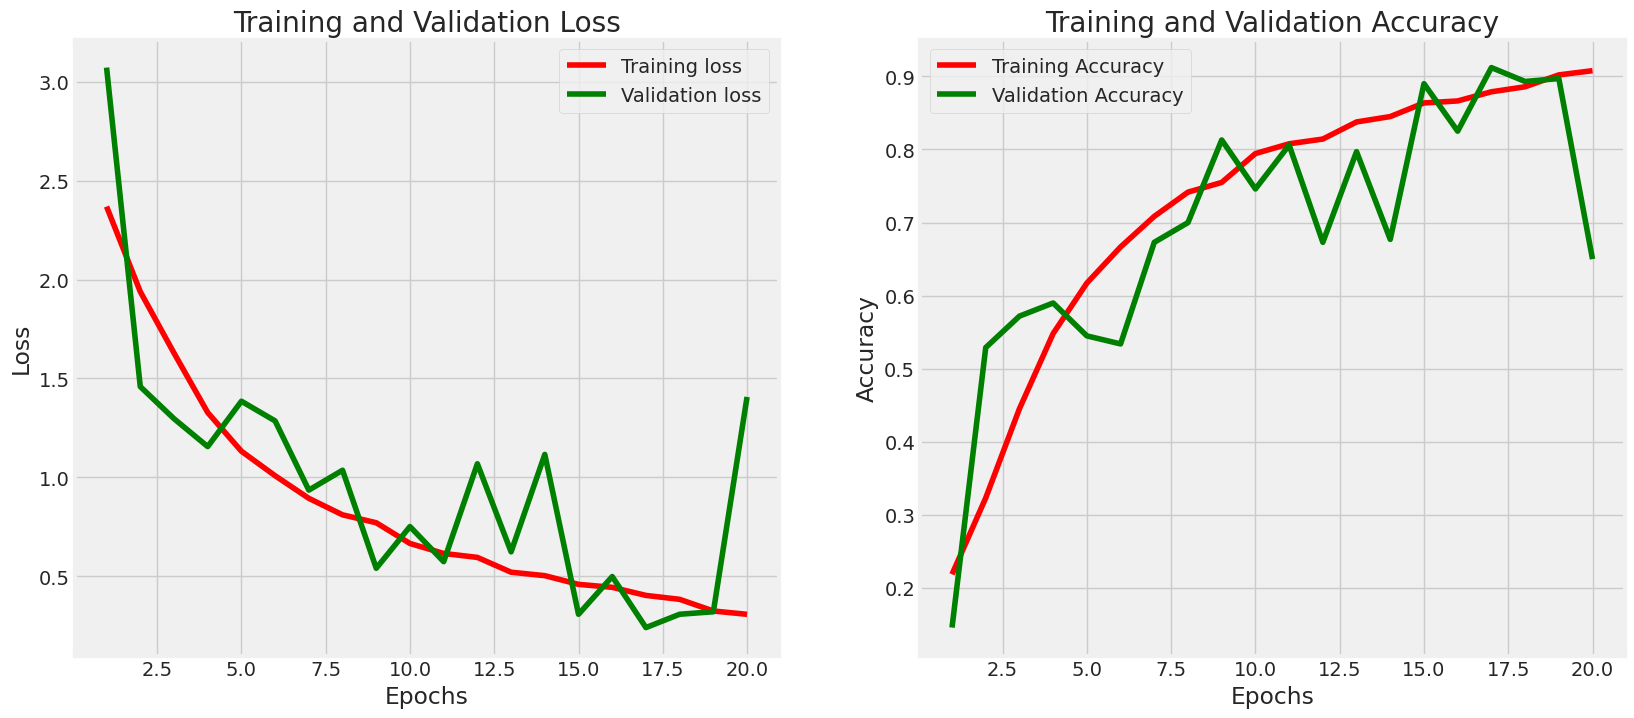

In [ ]:
model_performance(history, epochs)

In [ ]:
model_evaluation(cnn_model)

500/500 ━━━━━━━━━━━━━━━━━━━━ 16s 33ms/step - accuracy: 0.6564 - loss: 1.3554
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.6468 - loss: 1.3917
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 113ms/step - accuracy: 0.6365 - loss: 1.5070
Train Loss:  1.3593602180480957
Train Accuracy:  0.6508749723434448
--------------------
Validation Loss:  1.4116308689117432
Validation Accuracy:  0.6499999761581421
--------------------
Test Loss:  1.5068098306655884
Test Accuracy:  0.6309999823570251


 6/63 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step

W0000 00:00:1713196619.793167      77 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step


W0000 00:00:1713196622.654844      76 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


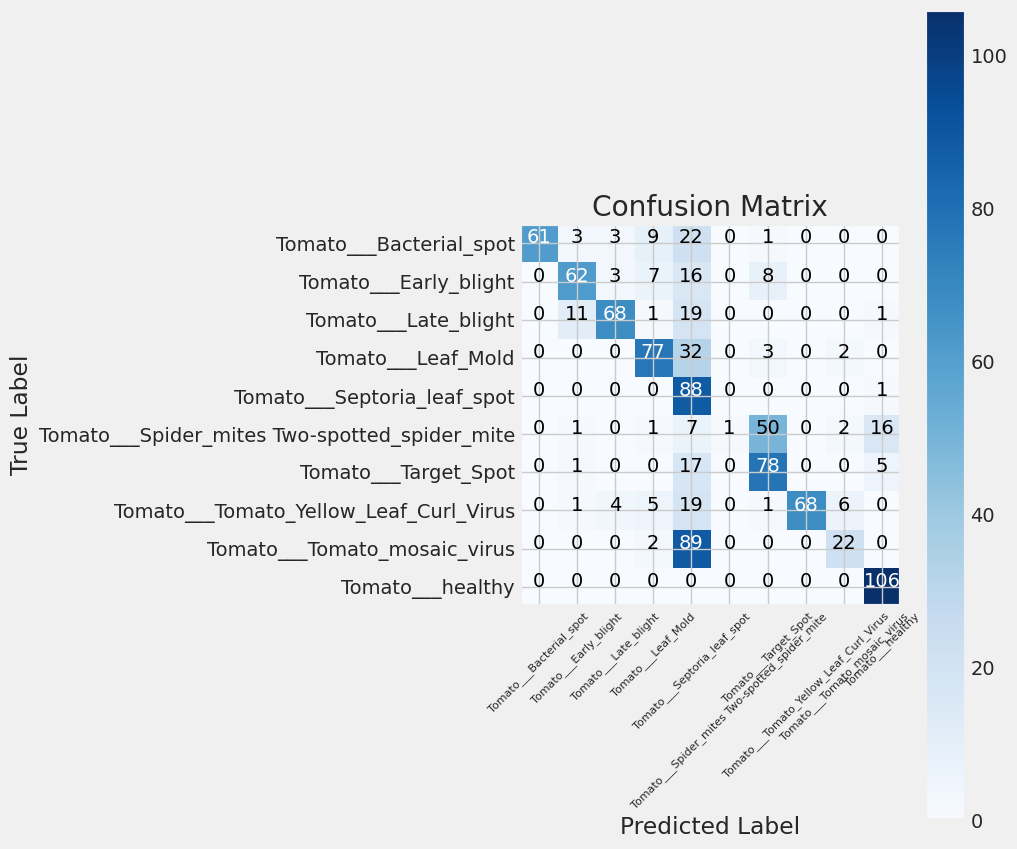

In [ ]:
y_pred = get_pred(cnn_model, test_gen)

plot_confusion_matrix(test_gen, y_pred)